In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from IPython.display import display
import gender_guesser.detector as gender
from ast import literal_eval
import pandas as pd

In [2]:
plt.rcParams['figure.figsize'] = (16, 9)

# ======================================================================
# 1. Load data from Excel
# ======================================================================
df = pd.read_excel('../data/dimensions/api/raw/combined/202511/df_dimensions.xlsx', index_col=0)



# Ensure 'year' exists and is numeric
if 'year' not in df.columns:
    raise ValueError("'year' column not found in the dataset.")
df['year'] = pd.to_numeric(df['year'], errors='coerce')

In [3]:
def split_list_field(value):

    if pd.isna(value):
        return []
    s = str(value)

    # Try to parse as Python literal list
    try:
        parsed = literal_eval(s)
        if isinstance(parsed, (list, tuple)):
            return [str(x).strip() for x in parsed if str(x).strip()]
    except Exception:
        pass

    # Fallback: split on common delimiters
    for sep in [';', '|']:
        if sep in s:
            return [x.strip() for x in s.split(sep) if x.strip()]

    # Last resort: single value
    s = s.strip()
    return [s] if s else []

In [4]:
# ======================================================================
# 1. Tables only (no figures)
# ======================================================================

# --- Countries exploded table ---
countries_df = (
    df[['id', 'year', 'research_org_country_names']]
    .assign(country_list=lambda d: d['research_org_country_names'].apply(split_list_field))
    .explode('country_list')
    .rename(columns={'country_list': 'country'})
)

countries_df = countries_df.dropna(subset=['country', 'year'])
countries_df['year'] = countries_df['year'].astype(int)

print("\nExploded (paper, year, country) table:")
display(countries_df.head())


# --- Country-level counts ---
country_counts = (
    countries_df
    .groupby('country')
    .agg(n_pubs=('id', 'nunique'))
    .reset_index()
    .sort_values('n_pubs', ascending=False)
)

print("\nTop countries by number of UKBB publications:")
display(country_counts.head(10))


# --- Institution-level counts (table only) ---
if 'research_org_names' in df.columns:
    orgs_df = (
        df[['id', 'year', 'research_org_names']]
        .assign(org_list=lambda d: d['research_org_names'].apply(split_list_field))
        .explode('org_list')
        .rename(columns={'org_list': 'org_name'})
    )

    orgs_df = orgs_df.dropna(subset=['org_name', 'year'])
    orgs_df['year'] = orgs_df['year'].astype(int)

    org_counts = (
        orgs_df.groupby('org_name')
        .agg(n_pubs=('id', 'nunique'))
        .reset_index()
        .sort_values('n_pubs', ascending=False)
    )

    print("\nTop institutions by number of UKBB publications:")
    display(org_counts.head(10))

else:
    print("\n'research_org_names' column not found — cannot print institution table.")



Exploded (paper, year, country) table:


,id,year,research_org_country_names,country
0,pub.1142697354,2021,"['China', 'Australia']",China
0,pub.1142697354,2021,"['China', 'Australia']",Australia
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",United Kingdom
1,pub.1107515670,2018,"['United Kingdom', 'Norway']",Norway
2,pub.1111460082,2019,"['United States', 'United Kingdom']",United States



Top countries by number of UKBB publications:


,country,n_pubs
117,United States,4228
116,United Kingdom,4205
21,China,3666
3,Australia,1269
106,Sweden,955
39,Germany,944
75,Netherlands,942
19,Canada,722
28,Denmark,520
36,France,487



Top institutions by number of UKBB publications:


,org_name,n_pubs
3270,Harvard University,1162
7529,University of Oxford,967
607,Broad Institute,678
4670,Massachusetts General Hospital,652
7319,University of Cambridge,553
7193,University College London,532
4256,King's College London,529
593,Brigham and Womens Hospital Inc,500
4165,Karolinska Institutet,498
3655,Imperial College London,494


In [5]:

# ======================================================================
# 5. Choropleth map with GeoPandas
# ======================================================================

# Natural Earth 1:110m countries shapefile (public URL)
world_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(world_url)

print("\nWorld shapefile example:")
display(world[['ADMIN', 'ISO_A3_EH']].head())

# Basic name harmonisation — extend as needed once you see mismatches

name_map = {
    'USA': 'United States of America',
    'US': 'United States of America',
    'United States': 'United States of America',
    'UK': 'United Kingdom',
    'Russia': 'Russian Federation',
    # Add more mappings as needed
}

country_counts['country_norm'] = country_counts['country'].replace(name_map)

world_counts = world.merge(
    country_counts,
    how='left',
    left_on='ADMIN',
    right_on='country_norm'
)

world_counts['n_pubs'] = world_counts['n_pubs'].fillna(0)


World shapefile example:


,ADMIN,ISO_A3_EH
0,Fiji,FJI
1,United Republic of Tanzania,TZA
2,Western Sahara,ESH
3,Canada,CAN
4,United States of America,USA


In [6]:
# ----------------------------------------------------------------------
# 3.1 Country-level counts for choropleth
# ----------------------------------------------------------------------
country_counts = (
    countries_df
    .groupby('country')
    .agg(n_pubs=('id', 'nunique'))
    .reset_index()
    .sort_values('n_pubs', ascending=False)
)

print("\nTop countries by number of UKBB publications:")
display(country_counts.head(10))

# ----------------------------------------------------------------------
# 3.2 Speed of uptake: cumulative count of distinct countries over time
# ----------------------------------------------------------------------
year_country = (
    countries_df[['year', 'country']]
    .drop_duplicates()
    .sort_values(['year', 'country'])
)

years = sorted(year_country['year'].unique())
cum_counts = []
seen = set()

for y in years:
    subset = year_country[year_country['year'] == y]['country']
    seen.update(subset)
    cum_counts.append({'year': y, 'cum_countries': len(seen)})

uptake_df = pd.DataFrame(cum_counts)


Top countries by number of UKBB publications:


,country,n_pubs
117,United States,4228
116,United Kingdom,4205
21,China,3666
3,Australia,1269
106,Sweden,955
39,Germany,944
75,Netherlands,942
19,Canada,722
28,Denmark,520
36,France,487


In [11]:

# ======================================================================
# 4. by institution
# ======================================================================
if 'research_org_names' in df.columns:
    orgs_df = (
        df[['id', 'year', 'research_org_names']]
        .assign(org_list=lambda d: d['research_org_names'].apply(split_list_field))
        .explode('org_list')
        .rename(columns={'org_list': 'org_name'})
    )

    orgs_df = orgs_df.dropna(subset=['org_name', 'year'])
    orgs_df['year'] = orgs_df['year'].astype(int)

    year_org = (
        orgs_df[['year', 'org_name']]
        .drop_duplicates()
        .sort_values(['year', 'org_name'])
    )

    years_org = sorted(year_org['year'].unique())
    cum_counts_org = []
    seen_orgs = set()

    for y in years_org:
        subset = year_org[year_org['year'] == y]['org_name']
        seen_orgs.update(subset)
        cum_counts_org.append({'year': y, 'cum_orgs': len(seen_orgs)})

    uptake_org_df = pd.DataFrame(cum_counts_org)
else:
    print("\n'research_org_names' column not found - skipping institution uptake analysis.")



/tmp/ipykernel_76983/799470455.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("cividis")


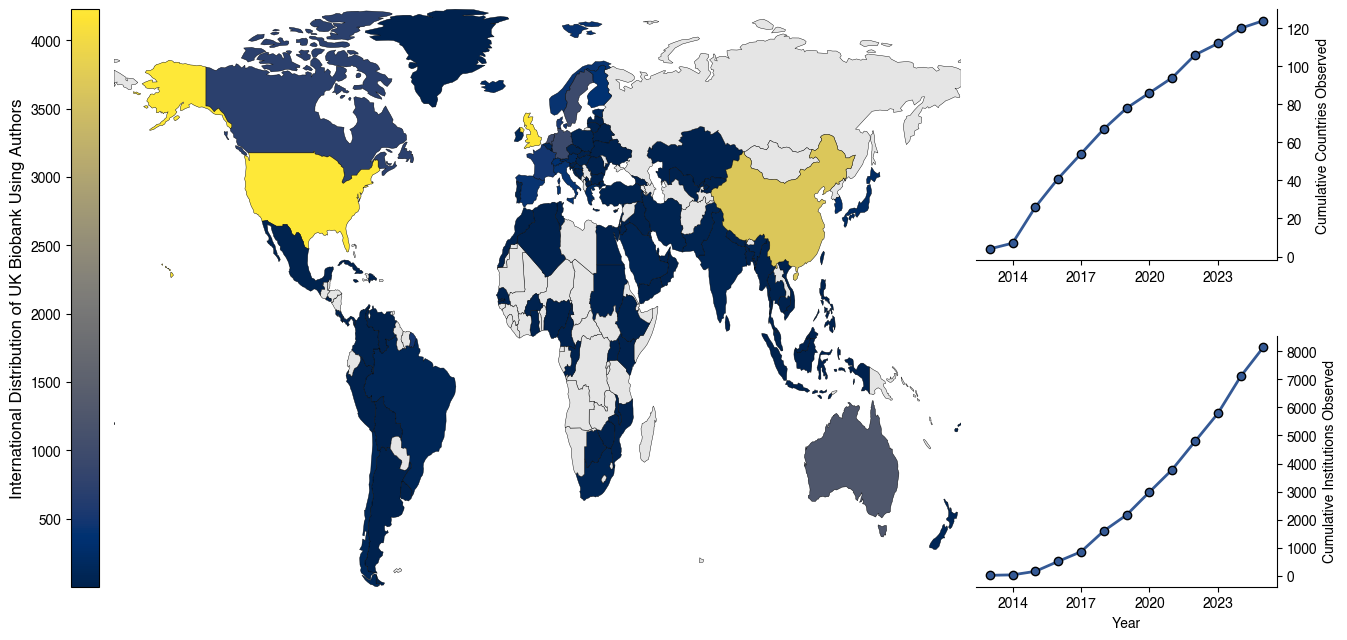

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
import matplotlib.cm as cm
import matplotlib.colors as colors

plt.rcParams['font.family'] = 'Helvetica'

plt.close('all')

# ============================================================
# 1. Build viridis colours but force zeros to white
# ============================================================

world_counts = world_counts[world_counts["ADMIN"] != "Antarctica"]

# Normalise only over non-zero values
nonzero = world_counts.loc[world_counts['n_pubs'] > 0, 'n_pubs']
norm = colors.Normalize(vmin=nonzero.min(), vmax=nonzero.max())
cmap = cm.get_cmap("cividis")

# Base colours from viridis
viridis_colors = cmap(norm(world_counts['n_pubs']))

# Softer grey for zero values
ZERO_COLOR = "#E5E5E5"

color_array = []
for n, c in zip(world_counts['n_pubs'], viridis_colors):
    if n == 0:
        color_array.append(ZERO_COLOR)
    else:
        color_array.append(colors.to_hex(c))


# ============================================================
# 2. Figure layout
# ============================================================

fig = plt.figure(figsize=(16, 7.5))
gs = GridSpec(
    2, 4,
    figure=fig,
    width_ratios=[0.15, 4.5, 1.6, 0.1],
    height_ratios=[1, 1],
    wspace=0.05,
    hspace=0.3
)


# ============================================================
# 3. MAP PANEL — viridis continuous, zeros white
# ============================================================

ax_map = fig.add_subplot(gs[:, 1])

world_counts.plot(
    ax=ax_map,
    color=color_array,          # explicit colors
    linewidth=0.3,
    edgecolor="black",
)

ax_map.set_aspect("auto")
#ax_map.set_title("International Distribution of UK Biobank Using Authors")
ax_map.margins(0)
ax_map.set_anchor('W')
ax_map.set_axis_off()


# ============================================================
# 4. Colourbar (continuous viridis, no white)
# ============================================================

ax_cbar = fig.add_subplot(gs[:, 0])

sm = cm.ScalarMappable(
    cmap=cmap,
    norm=colors.Normalize(vmin=nonzero.min(), vmax=nonzero.max())
)
sm._A = []

cbar = fig.colorbar(sm, cax=ax_cbar, orientation='vertical')
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.set_label("International Distribution of UK Biobank Using Authors", fontsize=12)


# ============================================================
# 5. TOP RIGHT — cumulative countries
# ============================================================

ax1 = fig.add_subplot(gs[0, 2])
ax1.plot(uptake_df['year'], uptake_df['cum_countries'],
    marker='o', linewidth=2, markersize=6, markeredgecolor='k', markerfacecolor='#345995', color='#345995')

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("Cumulative Countries Observed")

ax1.spines['left'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax1.tick_params(axis='y', right=True, left=False)
ax1.tick_params(axis='x', bottom=True, top=False)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
#ax1.grid(True, alpha=0.3)


# ============================================================
# 6. BOTTOM RIGHT — cumulative institutions
# ============================================================

ax2 = fig.add_subplot(gs[1, 2])

ax2.plot(uptake_org_df['year'], uptake_org_df['cum_orgs'],
    marker='o', linewidth=2, markersize=6, markeredgecolor='k', markerfacecolor='#345995', color='#345995')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Cumulative Institutions Observed")
ax2.set_xlabel("Year")

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.tick_params(axis='y', right=True, left=False)
ax2.tick_params(axis='x', bottom=True, top=False)

ax2.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=5))
#ax2.grid(True, alpha=0.2)

#ax1.set_title("Cumulative Countries Observed")
#ax2.set_title("Cumulative Institutions Observed")


# ============================================================
# 7. Spacer
# ============================================================

ax_blank = fig.add_subplot(gs[:, 3])
ax_blank.set_axis_off()
plt.savefig("../output/figures/geography.pdf", bbox_inches='tight')
plt.savefig("../output/figures/geography.svg", bbox_inches='tight')
plt.savefig("../output/figures/geography.png", bbox_inches='tight', dpi=800)